<a href="https://colab.research.google.com/github/sk95068/Mahbub_MCSE/blob/main/UNet_CamVid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive');

Mounted at /content/gdrive


In [3]:
def load_img(folder):
  #an iter variable
    images = []
    labels = []
    f = os.listdir(folder)
    for filename in f: 
        img = cv2.imread(os.path.join(folder, filename)) 
        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        lbl= cv2.imread(os.path.join(folder+'annot', filename))
        lbl= cv2.resize(lbl, (128, 128), interpolation = cv2.INTER_AREA)
        images.append(img)
        labels.append(lbl)
        #print(os.listdir(images))
    return images, labels


In [4]:

transform_img = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
transform_img_label = transforms.Compose([transforms.ToTensor()])

In [5]:
from torch.utils.data import Dataset, DataLoader

#Advance Dataloaders

class trainset(data.Dataset):
    def __init__(self, transform = None, root_train = None, root_train_label = None, transform_label = None):
        self.train_img, self.train_labels = load_img(root_train)
        self.transform = transform
        self.transform_label = transform_label
        #self.train_label_img = label_img_list(load_img(root_train_label))
        
    def __len__(self):
        return len(self.train_img)
    
    def __getitem__(self, index):
        img = self.transform(self.train_img[index])
        label = self.transform_label(self.train_labels[index])
        
        return img, label
          
class valset(data.Dataset):
    def __init__(self, transform = None, root_val = None, root_val_label = None, transform_label = None):
        self.val_img, self.val_labels = load_img(root_val)
        self.transform = transform
        self.transform_label = transform_label
        #self.test_label_img = label_img_list(load_img1(root_test_label))
        
    def __len__(self):
        return len(self.val_img)
    
    def __getitem__(self, index):
        img = self.transform(self.val_img[index])
        label = self.transform_label(self.val_labels[index])
        
        return img, label
class testset(data.Dataset):
    def __init__(self, transform = None, root_test = None, root_test_label = None, transform_label = None):
        self.val_img = load_img(root_test)
        self.transform = transform
        self.transform_label = transform_label
        #self.test_label_img = label_img_list(load_img1(root_test_label))
        
    def __len__(self):
        return len(self.test_img)
    
    def __getitem__(self, index):
        img = self.transform(self.test_img[index])
        label = self.transform_label(self.test_label_img[index])
        
        return img, label        
  

traindataset = trainset(transform_img, '/content/gdrive/MyDrive/CamVid/CamVid/train', '/content/gdrive/MyDrive/CamVid/CamVid/trainannot', transform_img_label)

testdataset = testset(transform_img , '/content/gdrive/MyDrive/CamVid/CamVid/test', '/content/gdrive/MyDrive/CamVid/CamVid/testannot', transform_img_label)

valdataset = valset(transform_img, '/content/gdrive/MyDrive/CamVid/CamVid/val', '/content/gdrive/MyDrive/CamVid/CamVid/valannot', transform_img_label)

       


In [6]:
class u_net(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 64, 3)
      self.conv2 = nn.Conv2d(64, 128, 3)
      self.conv3 = nn.Conv2d(128, 256, 3)
      self.conv4 = nn.Conv2d(256, 512, 3)
      self.conv5 = nn.Conv2d(512, 1024, 3)
      self.conv6 = nn.Conv2d(1024, 512, 3)
      self.conv7 = nn.Conv2d(512, 512, 3)
      self.conv8 = nn.Conv2d(512, 256, 3)
      self.conv9 = nn.Conv2d(256, 256, 3)
      self.conv10 = nn.Conv2d(256, 128, 3)
      self.conv11 = nn.Conv2d(128, 128, 3)
      self.conv12 = nn.Conv2d(64, 64, 3)
      self.b1 = nn.BatchNorm2d(64)
      self.b2 = nn.BatchNorm2d(128)
      self.b3 = nn.BatchNorm2d(256)
      self.b4 = nn.BatchNorm2d(512)
      self.b5 = nn.BatchNorm2d(1024)
      self.convT1 = nn.ConvTranspose2d(1024, 512, 2, 2)
      self.convT2 = nn.ConvTranspose2d(512, 256, 2, 2)
      self.convT3 = nn.ConvTranspose2d(256, 256, 2, 2)
      self.convT4 = nn.ConvTranspose2d(128, 64, 2, 2)
      self.convT5 = nn.ConvTranspose2d(64, 12, 2, 2)
      self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
      x = F.relu(self.b1(self.conv1(x)))
      x = F.relu(self.b1(self.conv12(x)))
      x = F.relu(self.b2(self.conv2(x)))
      x = self.pool1(x)
      x = F.relu(self.b2(self.conv11(x)))
      x = F.relu(self.b3(self.conv3(x)))
      x1 = x
      x1 = x1[:, :, int((58 - 24)/2) : int((58 + 24)/2), int((58 - 24)/2) : int((58 + 24)/2)];
      x = self.pool1(x)
      x = F.relu(self.b3(self.conv9(x)))
      x = F.relu(self.b4(self.conv4(x)))
      x2 = x
      x2 = x2[:, :, int((25 - 16)/2) : int((25 + 16)/2), int((25 - 16)/2) : int((25 + 16)/2)];
      x = self.pool1(x)
      x = F.relu(self.b4(self.conv7(x)))
      x = F.relu(self.b5(self.conv5(x)))
      x = self.b4(self.convT1(x))
      x = torch.cat((x2, x), dim = 1)
      x = F.relu(self.b4(self.conv6(x)))
      x = F.relu(self.b4(self.conv7(x)))
      x = self.b3(self.convT2(x))
      x = torch.cat((x1, x), dim = 1)
      x = F.relu(self.b3(self.conv8(x)))
      x = F.relu(self.b3(self.conv9(x)))
      x = self.b3(self.convT3(x))
      x = F.relu(self.b2(self.conv10(x)))
      x = F.relu(self.b2(self.conv11(x)))
      x = F.relu(self.b2(self.conv11(x)))
      x = F.relu(self.b2(self.conv11(x)))
      x = self.b1(self.convT4(x))
      x = self.convT5(x)
      del x1
      del x2
      return x
net = u_net()


In [7]:
from PIL import Image
train_loader = data.DataLoader(traindataset, batch_size = 4, shuffle=True)
val_loader =data.DataLoader(valdataset, batch_size=4,shuffle=False)

print(train_loader)

for images,label in train_loader:
  #print(images)
  #print(type(images))
  x = torch.unique(label)*256
  x = torch.round(x)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#UNET = net
net.to(device)

cuda:0


u_net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (b1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [9]:
loss1 = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001, betas = (0.9, 0.999), eps = 1e-08, weight_decay=0, amsgrad=False)

In [20]:
PATH = './camvid.pth'
val_loss_min=999999
net_min=net.state_dict()
otp_min=optimizer.state_dict()
loss_set=[]
#net= net.cuda()
print('Start Training')
for epoch in range(100):  
    train_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(train_loader,0):
      # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        #inputs=inputs.cuda()
        #labels=labels.cuda()
        x = labels*256
        x = torch.round(x)
        labels = x
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        outputs = nn.functional.softmax(outputs, dim=1)
        labels = labels[:,0,:,:]
        labels=labels.squeeze(1)
        labels = labels.long()
        loss = loss1(outputs, labels)
        _, predicted = torch.max(outputs, dim=1)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
       
    train_loss = running_loss/4.0
    for i, data in enumerate(val_loader, 0):
        correct_val=0
        total_val =0
        val_loss =0.0
        inputs, labels = data
        #inputs=inputs.cuda()
        #labels=labels.cuda()
        x = labels*256
        x = torch.round(x)
        labels = x
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        outputs = nn.functional.softmax(outputs, dim=1)
        labels = labels[:,0,:,:]
        labels=labels.squeeze(1)
        labels = labels.long()
        
        val_loss = loss1(outputs, labels)
        _, predicted = torch.max(outputs, dim=1) 
        total_val+=labels.size(0)
        correct_val += (predicted == labels).sum().item()
        total_val += labels.nelement()
        #IOU_score
        intersection = np.logical_and(labels.cpu(), predicted.cpu())
        union = np.logical_or(labels.cpu(),predicted.cpu())
        iou_score = torch.sum(intersection)/torch.sum(union)
        
        
    if(val_loss<val_loss_min):

        net_min=net.state_dict()
        otp_min=optimizer.state_dict()
        
        torch.save(net.state_dict(), PATH)
        print("model saved")
        val_loss_min= val_loss
    val_accuracy = ((100*correct_val)/total_val)
    loss_set.append([train_loss,val_loss])

    print("for epoch",epoch,",training loss",train_loss,"validation loss",val_loss  , "accuracy : %d %%" %(val_accuracy), "IOU is %s" %iou_score)
print('Finished Training')

Start Training
model saved
for epoch 0 ,training loss 43.609149158000946 validation loss tensor(2.1306, device='cuda:0', grad_fn=<NllLoss2DBackward0>) accuracy : 48 % IOU is tensor(0.8196)
model saved
for epoch 1 ,training loss 43.30864292383194 validation loss tensor(2.0965, device='cuda:0', grad_fn=<NllLoss2DBackward0>) accuracy : 52 % IOU is tensor(0.7993)
for epoch 2 ,training loss 43.14097434282303 validation loss tensor(2.1192, device='cuda:0', grad_fn=<NllLoss2DBackward0>) accuracy : 50 % IOU is tensor(0.8426)
model saved
for epoch 3 ,training loss 42.975870221853256 validation loss tensor(2.0382, device='cuda:0', grad_fn=<NllLoss2DBackward0>) accuracy : 58 % IOU is tensor(0.8382)
for epoch 4 ,training loss 42.75690206885338 validation loss tensor(2.0710, device='cuda:0', grad_fn=<NllLoss2DBackward0>) accuracy : 55 % IOU is tensor(0.8145)
for epoch 5 ,training loss 42.65739268064499 validation loss tensor(2.0756, device='cuda:0', grad_fn=<NllLoss2DBackward0>) accuracy : 54 % IOU

In [21]:
from torch.utils.data import Dataset, DataLoader
test_loader = torch.utils.data.DataLoader(testdataset, batch_size = 4, shuffle=False)
for images,label in train_loader:
  x = torch.unique(label)*256
  x = torch.round(x)
    

In [22]:
from PIL import Image
import torch
import cv2

# look at how the network performs on the whole dataset.
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        x = labels*256
        x = torch.round(x)
        labels = x
        #inputs=inputs.cuda()
        #labels=labels.cuda()
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = net(inputs)
        outputs = nn.functional.softmax(outputs, dim=1)
        labels = labels[:,0,:,:]
        labels=labels.squeeze(1)
        labels = labels.long()
        val_loss = loss1(outputs, labels)
        _, predicted = torch.max(outputs, dim=1)        
        total_val+=labels.size(0)
        correct_val += (predicted == labels).sum().item()
        total_val += labels.nelement()        
        # calculate outputs by running images through the network        
    val_accuracy = ((100*correct_val)/total_val)
print('Accuracy of the network on the 300 val images: %d %%' % (val_accuracy))


Accuracy of the network on the 300 val images: 48 %


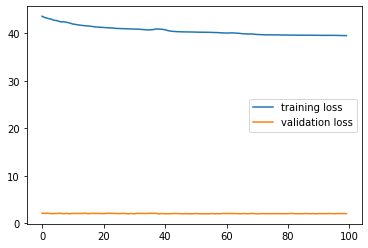

In [23]:
import matplotlib.pyplot as plt


train_loss_line=[]
val_loss_line=[]
x=[]
for i in range(len(loss_set)):
  train_loss_line.append(loss_set[i][0])
  val_loss_line.append(loss_set[i][1])
  x.append(i)
plt.plot(x, train_loss_line, label = "training loss")
plt.plot(x, val_loss_line , label = "validation loss")
plt.legend()
plt.show()


In [24]:
import numpy as np
import torch
import torch.nn.functional as F
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        x = labels*256
        x = torch.round(x)
        labels = x

        inter =np.logical_and(labels.cpu(), predicted.cpu())
        union =np.logical_or(labels.cpu(),predicted.cpu())
        iou_score= torch.sum(inter)/torch.sum(union)
print('IOU is %s' %iou_score)



   

IOU is tensor(0.8854)
